## Load libraries and retrieve dataset

In [19]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os,random
from skimage import io, color, exposure, transform
from skimage.morphology import disk
from skimage.util import img_as_ubyte
from skimage.filters import rank
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import TensorBoard
import h5py

In [20]:
df = pd.read_csv("GTSRB/origine/Test.csv", header=0)
display(df.head(10))

,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,Path
0,53,54,6,5,48,49,16,Test/00000.png
1,42,45,5,5,36,40,1,Test/00001.png
2,48,52,6,6,43,47,38,Test/00002.png
3,27,29,5,5,22,24,33,Test/00003.png
4,60,57,5,5,55,52,11,Test/00004.png
5,52,56,5,5,47,51,38,Test/00005.png
6,147,130,12,12,135,119,18,Test/00006.png
7,32,33,5,5,26,28,12,Test/00007.png
8,45,50,6,5,40,45,25,Test/00008.png
9,81,86,7,7,74,79,35,Test/00009.png


In [21]:
def  read_csv_dataset(csv_file): 
    '''
    Reads traffic sign data from German Traffic Sign Recognition Benchmark dataset.
    Arguments:  
        csv filename :  Description file, Example /data/GTSRB/Train.csv
    Returns:
        x,y          :  np array of images, np array of corresponding labels
    '''

    path = os.path.dirname(csv_file)
    name = os.path.basename(csv_file)

    # ---- Read csv file
    #
    df = pd.read_csv(csv_file, header=0)
    
    # ---- Get filenames and ClassIds
    #
    filenames = df['Path'].to_list()
    y         = df['ClassId'].to_list()
    x         = []
    
    
    # ---- Read images
    #
    for filename in filenames:
        image=io.imread(f'{path}/{filename}')
        x.append(image)
        
    # ---- Return
    #
    return np.array(x,dtype=object),np.array(y)


def shuffle_np_dataset(x, y):
    """
    Shuffle a dataset (x,y)
    args:
        x,y : dataset
    return:
        x,y mixed
    """
    assert (len(x) == len(y)), "x and y must have same size"
    p = np.random.permutation(len(x))
    return x[p], y[p]

In [22]:
# ---- Read datasets

(x_train,y_train) = read_csv_dataset('GTSRB/origine/Train.csv')
(x_test ,y_test)  = read_csv_dataset('GTSRB/origine/Test.csv')
(x_meta ,y_meta)  = read_csv_dataset('GTSRB/origine/Meta.csv')


# ---- Shuffle train set

x_train, y_train = shuffle_np_dataset(x_train, y_train)

# ---- Sort Meta

combined = list(zip(x_meta,y_meta))
combined.sort(key=lambda x: x[1])
x_meta,y_meta = zip(*combined)

In [23]:
train_size  = []
train_ratio = []
train_lx    = []
train_ly    = []

test_size   = []
test_ratio  = []
test_lx     = []
test_ly     = []

for image in x_train:
    (lx,ly,lz) = image.shape
    train_size.append(lx*ly/1024)
    train_ratio.append(lx/ly)
    train_lx.append(lx)
    train_ly.append(ly)

for image in x_test:
    (lx,ly,lz) = image.shape
    test_size.append(lx*ly/1024)
    test_ratio.append(lx/ly)
    test_lx.append(lx)
    test_ly.append(ly)

x_train shape :  (39209,)
y_train shape :  (39209,)
x_test  shape :  (12630,)
y_test  shape :  (12630,)


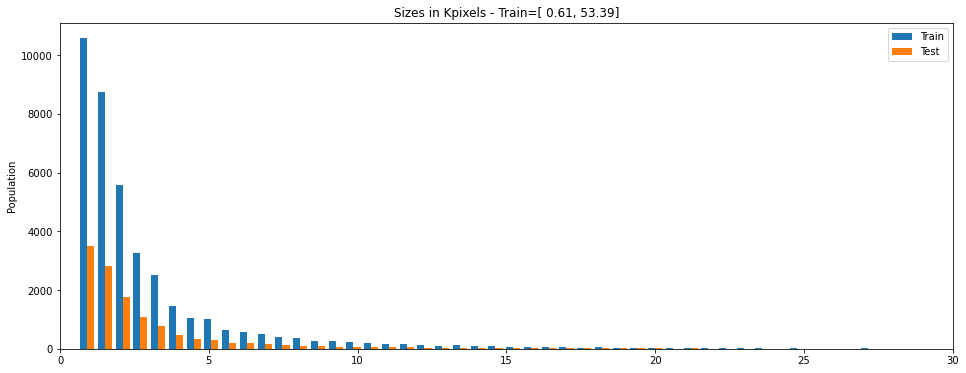

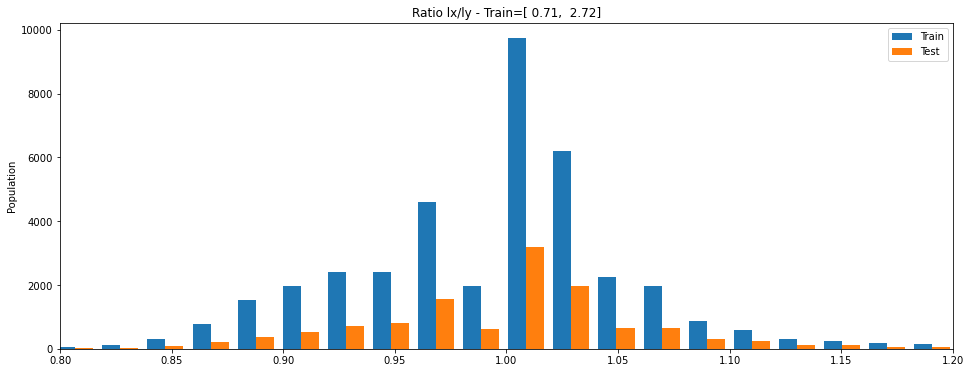

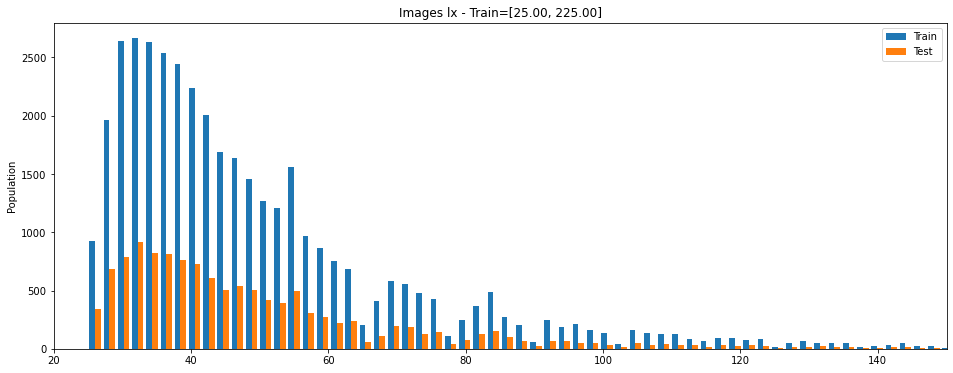

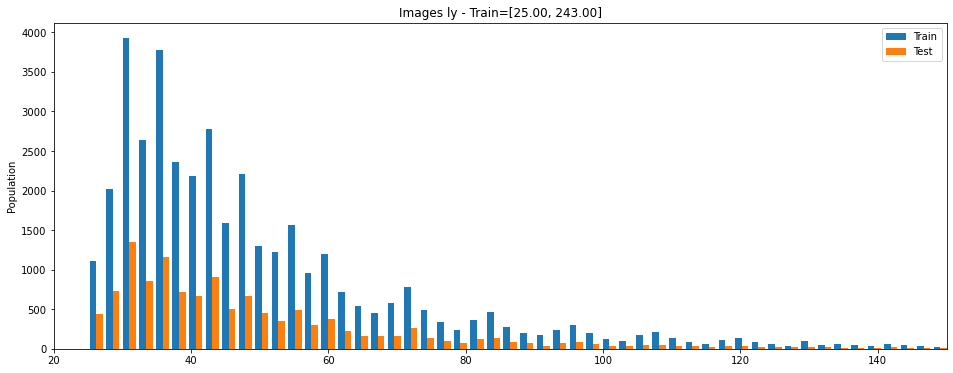

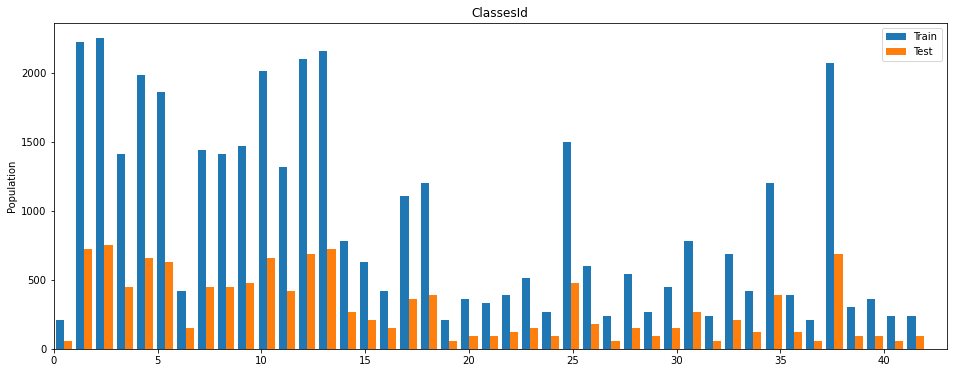

In [24]:
# ------ Global stuff
print("x_train shape : ",x_train.shape)
print("y_train shape : ",y_train.shape)
print("x_test  shape : ",x_test.shape)
print("y_test  shape : ",y_test.shape)

# ------ Statistics / sizes
plt.figure(figsize=(16,6))
plt.hist([train_size,test_size], bins=100)
plt.gca().set(title='Sizes in Kpixels - Train=[{:5.2f}, {:5.2f}]'.format(min(train_size),max(train_size)), 
              ylabel='Population', xlim=[0,30])
plt.legend(['Train','Test'])
plt.show()

# ------ Statistics / ratio lx/ly
plt.figure(figsize=(16,6))
plt.hist([train_ratio,test_ratio], bins=100)
plt.gca().set(title='Ratio lx/ly - Train=[{:5.2f}, {:5.2f}]'.format(min(train_ratio),max(train_ratio)), 
              ylabel='Population', xlim=[0.8,1.2])
plt.legend(['Train','Test'])
plt.show()

# ------ Statistics / lx
plt.figure(figsize=(16,6))
plt.hist([train_lx,test_lx], bins=100)
plt.gca().set(title='Images lx - Train=[{:5.2f}, {:5.2f}]'.format(min(train_lx),max(train_lx)), 
              ylabel='Population', xlim=[20,150])
plt.legend(['Train','Test'])
plt.show()

# ------ Statistics / ly
plt.figure(figsize=(16,6))
plt.hist([train_ly,test_ly], bins=100)
plt.gca().set(title='Images ly - Train=[{:5.2f}, {:5.2f}]'.format(min(train_ly),max(train_ly)), 
              ylabel='Population', xlim=[20,150])
plt.legend(['Train','Test'])
plt.show()

# ------ Statistics / classId
plt.figure(figsize=(16,6))
plt.hist([y_train,y_test], bins=43)
plt.gca().set(title='ClassesId', ylabel='Population', xlim=[0,43])
plt.legend(['Train','Test'])
plt.show()

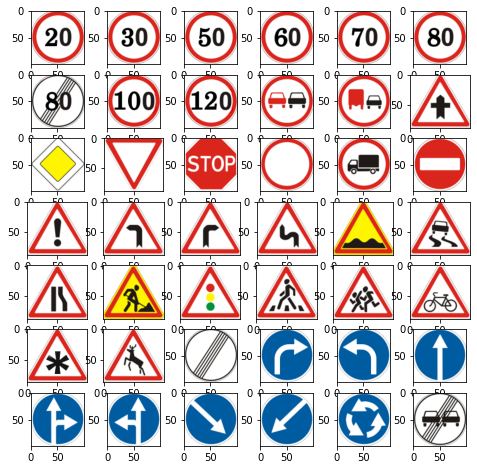

In [25]:
fig = plt.figure(figsize=(8, 8)) 
columns = 6 
rows = 7 
for i in range(1,columns*rows+1): 
    fig.add_subplot(rows, columns, i) 
    plt.imshow(x_meta[i-1]) 
plt.show()

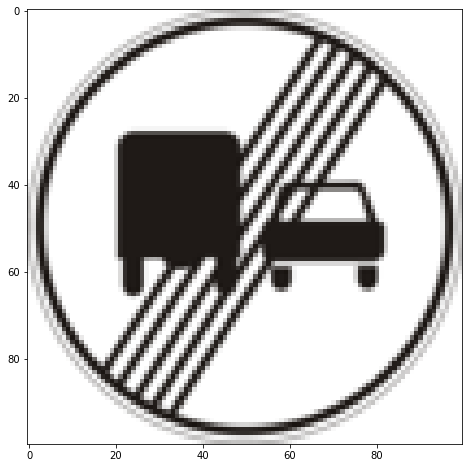

In [26]:
# Display the last class image
fig = plt.figure(figsize=(8, 8)) 
plt.imshow(x_meta[-1])
plt.show()

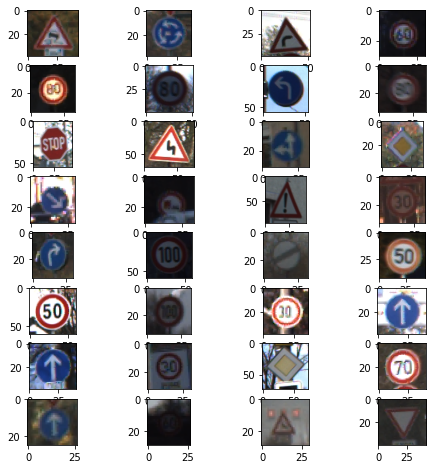

In [27]:
fig = plt.figure(figsize=(8, 8)) 
samples = [ random.randint(0,len(x_train)-1) for i in range(32)]
columns = 4 
rows = 8
for i in range(1,columns*rows+1): 
    fig.add_subplot(rows, columns, i) 
    plt.imshow(x_train[i-1]) 
plt.show()

In [28]:
def images_enhancement(images, width=25, height=25, mode='RGB'):
    '''
    Resize and convert images - doesn't change originals.
    input images must be RGBA or RGB.
    Note : all outputs are fixed size numpy array of float64
    args:
        images :         images list
        width,height :   new images size (25,25)
        mode :           RGB | RGB-HE | L | L-HE | L-LHE | L-CLAHE
    return:
        numpy array of enhanced images
    '''
    modes = { 'RGB':3, 'RGB-HE':3, 'L':1, 'L-HE':1, 'L-LHE':1, 'L-CLAHE':1}
    lz=modes[mode]
    
    out=[]
    for img in images:
        
        # ---- if RGBA, convert to RGB
        if img.shape[2]==4:
            img=color.rgba2rgb(img)
            
        # ---- Resize
        img = transform.resize(img, (width,height))

        # ---- RGB / Histogram Equalization
        if mode=='RGB-HE':
            hsv = color.rgb2hsv(img.reshape(width,height,3))
            hsv[:, :, 2] = exposure.equalize_hist(hsv[:, :, 2])
            img = color.hsv2rgb(hsv)
        
        # ---- Grayscale
        if mode=='L':
            img=color.rgb2gray(img)
            
        # ---- Grayscale / Histogram Equalization
        if mode=='L-HE':
            img=color.rgb2gray(img)
            img=exposure.equalize_hist(img)
            
        # ---- Grayscale / Local Histogram Equalization
        if mode=='L-LHE':        
            img=color.rgb2gray(img)
            img = img_as_ubyte(img)
            img=rank.equalize(img, disk(10))/255.
        
        # ---- Grayscale / Contrast Limited Adaptive Histogram Equalization (CLAHE)
        if mode=='L-CLAHE':
            img=color.rgb2gray(img)
            img=exposure.equalize_adapthist(img)
            
        # ---- Add image in list of list
        out.append(img)
       

    # ---- Reshape images
    #     (-1, width,height,1) for L
    #     (-1, width,height,3) for RGB
    #
    out = np.array(out,dtype='float64')
    out = out.reshape(-1,width,height,lz)
    return out

Expected


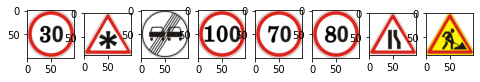

Original


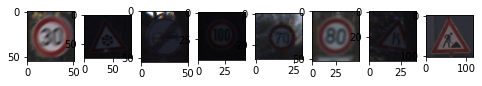

dataset : RGB  min,max=[0.027,1.000]  shape=(16, 25, 25, 3)


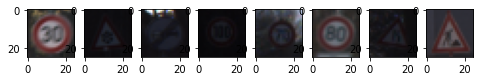

dataset : RGB-HE  min,max=[0.001,1.000]  shape=(16, 25, 25, 3)


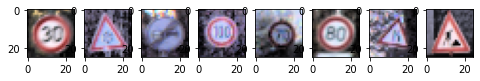

dataset : L  min,max=[0.027,1.000]  shape=(16, 25, 25, 1)


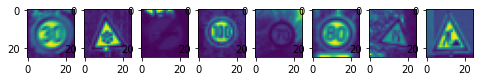

dataset : L-HE  min,max=[0.002,1.000]  shape=(16, 25, 25, 1)


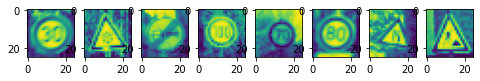

dataset : L-LHE  min,max=[0.000,1.000]  shape=(16, 25, 25, 1)


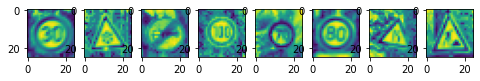

dataset : L-CLAHE  min,max=[0.000,1.000]  shape=(16, 25, 25, 1)


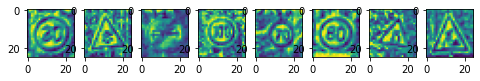

In [48]:
i=random.randint(0,len(x_train)-16)
x_samples = x_train[i:i+16]
y_samples = y_train[i:i+16]

def plot(columns,rows,image):
    fig = plt.figure(figsize=(8, 8)) 
    for i in range(1,columns*rows+1):
        fig.add_subplot(rows, columns, i)
        plt.imshow(image[i-1]) 
    plt.show()

datasets  = {}

datasets['RGB']      = images_enhancement( x_samples, width=25, height=25, mode='RGB'  )
datasets['RGB-HE']   = images_enhancement( x_samples, width=25, height=25, mode='RGB-HE'  )
datasets['L']        = images_enhancement( x_samples, width=25, height=25, mode='L'  )
datasets['L-HE']     = images_enhancement( x_samples, width=25, height=25, mode='L-HE'  )
datasets['L-LHE']    = images_enhancement( x_samples, width=25, height=25, mode='L-LHE'  )
datasets['L-CLAHE']  = images_enhancement( x_samples, width=25, height=25, mode='L-CLAHE'  )


x_expected=[ x_meta[i] for i in y_samples]

# Expected
print("Expected")
plot(8,1,x_expected)

# Original
print("Original")
plot(8,1,x_samples)

# Enhanced
n=10
for k,d in datasets.items():
    print("dataset : {}  min,max=[{:.3f},{:.3f}]  shape={}".format(k,d.min(),d.max(), d.shape))
    plot(8,1,datasets[k])


In [56]:
scale=0.2
n_train = int( len(x_train)*scale )
n_test  = int( len(x_test)*scale )

output_dir='GTSRB/origine/enhanced'

print(f'Scale is : {scale}')
print(f'x_train length is : {n_train}')
print(f'x_test  length is : {n_test}')
print(f'output dir is     : {output_dir}\n')

Scale is : 0.2
x_train length is : 7841
x_test  length is : 2526
output dir is     : GTSRB/origine/enhanced



In [54]:
def save_h5_dataset(x_train, y_train, x_test, y_test, x_meta,y_meta, filename):
        
    # ---- Create h5 file
    with h5py.File(filename, "w") as f:
        f.create_dataset("x_train", data=x_train)
        f.create_dataset("y_train", data=y_train)
        f.create_dataset("x_test",  data=x_test)
        f.create_dataset("y_test",  data=y_test)
        f.create_dataset("x_meta",  data=x_meta)
        f.create_dataset("y_meta",  data=y_meta)
        
    # ---- done
    size=os.path.getsize(filename)/(1024*1024)
    print('Dataset : {:24s}  shape : {:22s} size : {:6.1f} Mo   (saved)'.format(filename, str(x_train.shape),size))

In [57]:
os.makedirs(output_dir, mode=0o750, exist_ok=True)

for s in [24, 48]:
    for m in ['RGB', 'RGB-HE', 'L', 'L-LHE']:
        # ---- A nice dataset name
        filename = f'{output_dir}/set-{s}x{s}-{m}.h5'
        
        # ---- Enhancement
        #      Note : x_train is a numpy array of python objects (images with <> sizes)
        #             but images_enhancement() return a real array of float64 numpy (images with same size)
        #             so, we can save it in nice h5 files
        #
        x_train_new = images_enhancement( x_train[:n_train], width=s, height=s, mode=m )
        x_test_new  = images_enhancement( x_test[:n_test],  width=s, height=s, mode=m )
        x_meta_new  = images_enhancement( x_meta,  width=s, height=s, mode='RGB' )
        
        # ---- Save
        save_h5_dataset( x_train_new, y_train[:n_train], x_test_new, y_test[:n_test], x_meta_new,y_meta, filename)

x_train_new,x_test_new=0,0


Dataset : GTSRB/origine/enhanced/set-24x24-RGB.h5  shape : (7841, 24, 24, 3)      size :  137.3 Mo   (saved)
Dataset : GTSRB/origine/enhanced/set-24x24-RGB-HE.h5  shape : (7841, 24, 24, 3)      size :  137.3 Mo   (saved)
Dataset : GTSRB/origine/enhanced/set-24x24-L.h5  shape : (7841, 24, 24, 1)      size :   46.2 Mo   (saved)
Dataset : GTSRB/origine/enhanced/set-24x24-L-LHE.h5  shape : (7841, 24, 24, 1)      size :   46.2 Mo   (saved)
Dataset : GTSRB/origine/enhanced/set-48x48-RGB.h5  shape : (7841, 48, 48, 3)      size :  549.0 Mo   (saved)
Dataset : GTSRB/origine/enhanced/set-48x48-RGB-HE.h5  shape : (7841, 48, 48, 3)      size :  549.0 Mo   (saved)
Dataset : GTSRB/origine/enhanced/set-48x48-L.h5  shape : (7841, 48, 48, 1)      size :  184.5 Mo   (saved)
Dataset : GTSRB/origine/enhanced/set-48x48-L-LHE.h5  shape : (7841, 48, 48, 1)      size :  184.5 Mo   (saved)


In [58]:
dataset='set-48x48-L'
samples=range(24)

with  h5py.File(f'{output_dir}/{dataset}.h5','r') as f:
    x_tmp = f['x_train'][:]
    y_tmp = f['y_train'][:]
    print("dataset loaded from h5 file.")


dataset loaded from h5 file.


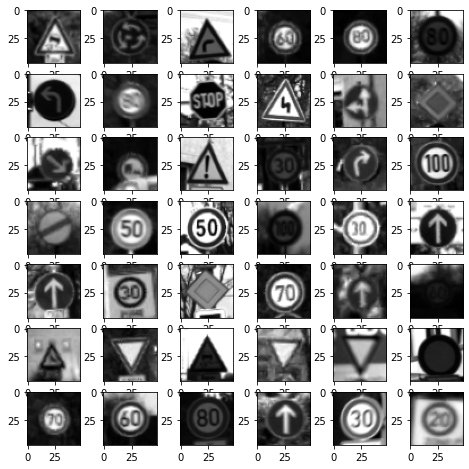

In [60]:
fig = plt.figure(figsize=(8, 8)) 
columns = 6 
rows = 7 
for i in range(1,columns*rows+1): 
    fig.add_subplot(rows, columns, i) 
    plt.imshow(x_tmp[i-1],cmap='gray') 
plt.show()